In [1]:
import time
import os
from sklearn.pipeline import _name_estimators 
import yaml
import pandas as pd
import numpy as np
#from dfply import *
import joblib
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from copy import deepcopy
from itertools import product
from collections import defaultdict
import graphviz 
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 12
import json
import shap

#os.chdir(os.path.dirname(__file__))
os.chdir("K:\\TEU\\TEU_Members\\Xiaonan_Liu\\Projects\\prsonbrstcancer")

with open('config.yml') as f:
    # use safe_load instead load
    config = yaml.safe_load(f)


def gnumeric_func (data, columns):
  data[columns] = data[columns].apply(lambda x: pd.factorize(x)[0]).replace(-1,np.nan)
  return data

tot_train=pd.read_feather(config['data']['derived']+"/tot_train.feather")
tot_test=pd.read_feather(config['data']['derived']+"/tot_test.feather")

print("tot_train shape: ", tot_train.shape)

# Load pretty_names list from R
with open(config['data']['derived']+'/full_pretty_names.json', 'r') as myfile:
    data=myfile.read()

pretty_names=json.loads(data)

pretty_names = {k:v[0] for k,v in pretty_names.items()}

pretty_names['TEU_BrCa_313_PRS']="$PRS_{313}$"
pretty_names['TEU_BrCa_100k_PRS']="$PRS_{120k}$"

tot_train shape:  (83450, 1752)


In [2]:
# Transform into HistGBM compatible format

predictors=[x for x in tot_train.columns if x not in ["TEU_BrCa_time","TEU_BrCa_status","ID","OtherCancerDx_Prevalent","GeP_Array"]+["GeP_PC_"+str(num1) for num1 in range(1,11)]]

# First make a copy of tot_train so that when dtrain get transformed, orginal data doesn't get changed
dtrain=tot_train[predictors].copy()

gnumeric_func(dtrain,dtrain.select_dtypes(include="category").columns) #dtrain will be auto transformed

# Get index of categorical vars
types=tot_train[predictors].dtypes
cat_index=np.where(types=='category')[0]

Y=tot_train['TEU_BrCa_status']

In [3]:
# Transform test set

dtest=tot_test[predictors].copy()

gnumeric_func(dtest,dtest.select_dtypes(include="category").columns) #dtrain will be auto transformed

# Get index of categorical vars
types=tot_test[predictors].dtypes
cat_index=np.where(types=='category')[0]

Ytest=tot_test['TEU_BrCa_status']

In [ ]:
# Step 1: Create baseline model

# Should try early stopping

HistGBM_baseline=HistGradientBoostingClassifier(
    loss='binary_crossentropy',
    learning_rate=0.1,
    max_iter=500,
    max_depth=2,
    max_leaf_nodes=None,
    min_samples_leaf=20,
    l2_regularization=0,
    max_bins=255, #default
    categorical_features=cat_index,
    monotonic_cst=None, #For now, we don't consider this contraint just yet
    # enable early stopping
    early_stopping='auto',
    scoring='roc_auc',
    validation_fraction=0.1,
    n_iter_no_change=50,
    random_state=27,
    verbose=1
)

baseline=HistGBM_baseline.fit(dtrain,Y)

In [ ]:
# Step 2: Tune tree-specific parameters

# In HistGBM, we only have 2 tree-specific parameters
param_test1 = {
 'max_depth':range(1,8,1),
 'min_samples_leaf':range(20,71,10)
}

gsearch1 = GridSearchCV(estimator = HistGradientBoostingClassifier(
    loss='binary_crossentropy',
    learning_rate=0.1,
    max_iter=150, #Obtained from previous step
    max_depth=1,
    max_leaf_nodes=None,
    min_samples_leaf=20,
    l2_regularization=0,
    max_bins=255, #default
    categorical_features=cat_index,
    monotonic_cst=None, #For now, we don't consider this contraint just yet
    # Disable early stopping for tuning hyper-parameter
    early_stopping=False,
    random_state=27
), 
 param_grid = param_test1, scoring='roc_auc', cv=5)
gsearch1.fit(dtrain,Y)

# Print results
print(gsearch1.cv_results_)
print(gsearch1.best_params_) 
print(gsearch1.best_score_)

joblib.dump(gsearch1, 'Data/Derived/HistGBM_gsearch1.pkl')

In [4]:
# Inspect results from above
gsearch1=joblib.load(config['data']['derived']+'/HistGBM_gsearch1.pkl')

gsearch1_df=pd.DataFrame({'max_depth': gsearch1.cv_results_["param_max_depth"],
 'min_samples_leaf': gsearch1.cv_results_["param_min_samples_leaf"],
 'acc': gsearch1.cv_results_["mean_test_score"]})

print(gsearch1_df.sort_values(by=['acc'],ascending=False))

   max_depth min_samples_leaf       acc
7          2               30  0.662992
9          2               50  0.662885
8          2               40  0.662470
6          2               20  0.662087
3          1               50  0.661980
4          1               60  0.661980
5          1               70  0.661974
2          1               40  0.661968
1          1               30  0.661955
0          1               20  0.661929
11         2               70  0.661857
10         2               60  0.661793
16         3               60  0.656923
13         3               30  0.656366
12         3               20  0.656019
17         3               70  0.655977
15         3               50  0.655692
14         3               40  0.654887
22         4               60  0.649129
23         4               70  0.648730
21         4               50  0.647879
19         4               30  0.647539
18         4               20  0.647097
20         4               40  0.646344


In [ ]:

# Step 2: Tune l2 regularisation

param_test2={
    'l2_regularization':[1e-5, 1e-2,0, 0.1, 1, 100]
}

gsearch2 = GridSearchCV(estimator = HistGradientBoostingClassifier(
    loss='binary_crossentropy',
    learning_rate=0.1,
    max_iter=150, #Obtained from previous step
    max_depth=2,
    max_leaf_nodes=None,
    min_samples_leaf=30,
    l2_regularization=0,
    max_bins=255, #default
    categorical_features=cat_index,
    monotonic_cst=None, #For now, we don't consider this contraint just yet
    # Disable early stopping for tuning hyper-parameter
    early_stopping=False,
    random_state=27
), 
 param_grid = param_test2, scoring='roc_auc', cv=5)
gsearch2.fit(dtrain,Y)

# Print results
gsearch2_df=pd.DataFrame({'l2_regularization': gsearch2.cv_results_["param_l2_regularization"],
 'acc': gsearch2.cv_results_["mean_test_score"]})

joblib.dump(gsearch2, 'Data/Derived/HistGBM_gsearch2.pkl')

In [ ]:
# More detailed tuning on l2_regularization

param_test2a={
    'l2_regularization':[1e-6,1e-5,5e-5,0,5,10,20]
}

gsearch2a = GridSearchCV(estimator = HistGradientBoostingClassifier(
    loss='binary_crossentropy',
    learning_rate=0.1,
    max_iter=150, #Obtained from previous step
    max_depth=2,
    max_leaf_nodes=None,
    min_samples_leaf=30,
    l2_regularization=0,
    max_bins=255, #default
    categorical_features=cat_index,
    monotonic_cst=None, #For now, we don't consider this contraint just yet
    # Disable early stopping for tuning hyper-parameter
    early_stopping=False,
    random_state=27
), 
 param_grid = param_test2a, scoring='roc_auc', cv=5)
gsearch2a.fit(dtrain,Y)

# Print results
gsearch2a_df=pd.DataFrame({'l2_regularization': gsearch2a.cv_results_["param_l2_regularization"],
 'acc': gsearch2a.cv_results_["mean_test_score"]})

joblib.dump(gsearch2a, 'Data/Derived/HistGBM_gsearch2a.pkl')

In [ ]:
# More detailed tuning on l2_regularization

param_test2b={
    'l2_regularization':range(20,51,5)
}

gsearch2b = GridSearchCV(estimator = HistGradientBoostingClassifier(
    loss='binary_crossentropy',
    learning_rate=0.1,
    max_iter=150, #Obtained from previous step
    max_depth=2,
    max_leaf_nodes=None,
    min_samples_leaf=30,
    l2_regularization=0,
    max_bins=255, #default
    categorical_features=cat_index,
    monotonic_cst=None, #For now, we don't consider this contraint just yet
    # Disable early stopping for tuning hyper-parameter
    early_stopping=False,
    random_state=27
), 
 param_grid = param_test2b, scoring='roc_auc', cv=5)
gsearch2b.fit(dtrain,Y)

# Print results
gsearch2b_df=pd.DataFrame({'l2_regularization': gsearch2b.cv_results_["param_l2_regularization"],
 'acc': gsearch2b.cv_results_["mean_test_score"]})

print(gsearch2b_df.sort_values(by=['acc'],ascending=False))

joblib.dump(gsearch2b, 'Data/Derived/HistGBM_gsearch2b.pkl')

In [8]:
# Show combined results
suffix=['','a','b']

gsearch2_total=[]

for i in suffix:
    gsearch=joblib.load(config['data']['derived']+'/HistGBM_gsearch2'+i+'.pkl')
    gsearch_df=pd.DataFrame({'l2_regularization': gsearch.cv_results_["param_l2_regularization"],
 'acc': gsearch.cv_results_["mean_test_score"]})
    gsearch2_total.append(gsearch_df)

gsearch2_total=pd.concat(gsearch2_total)
print(gsearch2_total.sort_values(by=['acc'],ascending=False))

  l2_regularization       acc
3                35  0.664309
2                30  0.664088
4                40  0.663987
1                25  0.663893
0                20  0.663763
6                20  0.663763
5                45  0.663635
4                 5  0.663603
5                10  0.663516
6                50  0.663286
2           0.00005  0.662992
1           0.00001  0.662992
0           0.00001  0.662992
0          0.000001  0.662992
3                 0  0.662992
2                 0  0.662992
5               100  0.662394
1              0.01  0.662286
4                 1  0.662238
3               0.1  0.661913


In [ ]:
# Lowering learning rate

def Search_lr(learning_rate,max_iter,n_iter_no_change):
    
    HistGBM_lr=HistGradientBoostingClassifier(
    loss='binary_crossentropy',
    learning_rate=learning_rate,
    max_iter=max_iter,
    max_depth=2,
    max_leaf_nodes=None,
    min_samples_leaf=30,
    l2_regularization=35,
    max_bins=255, #default
    categorical_features=cat_index,
    monotonic_cst=None, #For now, we don't consider this contraint just yet
    # enable early stopping
    early_stopping='auto',
    scoring='roc_auc',
    validation_fraction=0.1,
    n_iter_no_change=n_iter_no_change,
    random_state=27,
    verbose=1
)
    HistGBM_lr.fit(dtrain,Y)
    
    # print the optimal number of trees
    
    print("Optimal number of trees: {:.3f}",HistGBM_lr.n_iter_)
    print("Validation AUC for optimal number of trees: {}",HistGBM_lr.validation_score_[-1])
    
    return HistGBM_lr




Time taken for learning rate 0.1 is approx 35 sec.

In [ ]:
#  Lowering learning rate (lr=0.1)

# Note: Don't think we can create a function incorporate GridSearchCV with early stopping like in XGBoost
# Because HistGBM early stopping only allow validation_fraction

HistGBM_lr1=Search_lr(learning_rate=0.1,max_iter=500,n_iter_no_change=50)

joblib.dump(HistGBM_lr1,config['data']['derived']+"/HistGBM_lr1.sav")     

print("Done!")


In [9]:
# Show results from above
HistGBM_lr1=joblib.load(config['data']['derived']+"/HistGBM_lr1.sav")

print("For learning rate=0.1")
print("Optimal number of trees: ",HistGBM_lr1.n_iter_)
print("Validation AUC for optimal number of trees: %.5f" % HistGBM_lr1.validation_score_[-1])

For learning rate=0.1
Optimal number of trees:  151
Validation AUC for optimal number of trees: 0.65990


Time taken for learning rate 0.01 is approx 6min.

In [ ]:
HistGBM_lr2=Search_lr(learning_rate=0.01,max_iter=50000,n_iter_no_change=200)

joblib.dump(HistGBM_lr2,config['data']['derived']+"/HistGBM_lr2.sav")     

print("Done!")


In [10]:
# Show results from above
HistGBM_lr2=joblib.load(config['data']['derived']+"/HistGBM_lr2.sav")

print("For learning rate=0.01")
print("Optimal number of trees: ",HistGBM_lr2.n_iter_)
print("Validation AUC for optimal number of trees: %.5f" % HistGBM_lr2.validation_score_[-1])

For learning rate=0.01
Optimal number of trees:  1366
Validation AUC for optimal number of trees: 0.66396


Time taken for learning rate 0.001 is approx 3 hours.

In [ ]:
HistGBM_lr3=Search_lr(learning_rate=0.001,max_iter=50000,n_iter_no_change=200)

joblib.dump(HistGBM_lr3,config['data']['derived']+"/HistGBM_lr3.sav")     

print("Done!")

In [11]:
# Show results from above
HistGBM_lr3=joblib.load(config['data']['derived']+"/HistGBM_lr3.sav")

print("For learning rate=0.001")
print("Optimal number of trees: ",HistGBM_lr3.n_iter_)
print("Validation AUC for optimal number of trees: %.5f" % HistGBM_lr3.validation_score_[-1])

For learning rate=0.001
Optimal number of trees:  11501
Validation AUC for optimal number of trees: 0.66406


Considering computation time and relative improvent in performance, we chose the final model with learning rate 0.01.

In [12]:
# Fit the final model and get the cross-validation score

param_grid={
    'loss': 'binary_crossentropy',
    'learning_rate': 0.01,
    'max_iter': 1366,
    'max_depth': 2,
    'max_leaf_nodes':None,
    'min_samples_leaf':30,
    'l2_regularization': 35,
    'max_bins': 255,
    'categorical_features': cat_index,
    'monotonic_cst': None,
    'early_stopping': False,
    'random_state': 27
}

HistGBM_final=HistGradientBoostingClassifier(**param_grid)

cv_score=cross_val_score(HistGBM_final,dtrain,Y,cv=5,scoring='roc_auc')

print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

CV Score : Mean - 0.6639218 | Std - 0.01002944 | Min - 0.6500989 | Max - 0.6798662


In [4]:
# Fit final model

HistGBM_final=HistGradientBoostingClassifier(**param_grid)

HistGBM_final.fit(dtrain,Y)


HistGradientBoostingClassifier(categorical_features=array([   1,   11,   12, ..., 1635, 1636, 1637], dtype=int64),
                               early_stopping=False, l2_regularization=35,
                               learning_rate=0.01, loss='binary_crossentropy',
                               max_depth=2, max_iter=1366, max_leaf_nodes=None,
                               min_samples_leaf=30, random_state=27)

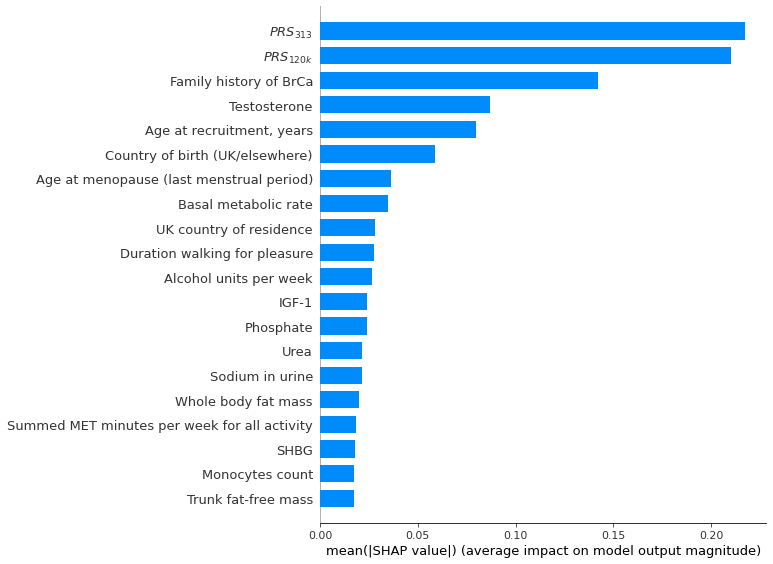

In [5]:
# Try SHAP values
explainer = shap.TreeExplainer(HistGBM_final) # Without specifying data, it would use feature_perturbation="tree_path_dependant" and fast!
shap_values = explainer.shap_values(dtrain)

# Get pretty names
feature_names = tot_train[predictors].columns

pretty_features=np.asarray([pretty_names[var] for var in feature_names])

# summary plot
shap.summary_plot(shap_values,pretty_features,plot_type="bar")

In [6]:
# Export full SHAP to csv
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(feature_names,pretty_features,vals)),columns=['Var_name','Full_name','SHAP'])
feature_importance.sort_values(by=['SHAP'],ascending=False,inplace=True)
print(feature_importance.head(10))

feature_importance.to_csv("K:/TEU/MLforBrCa/Stats_Outputs/HistGBM_SHAP.csv")

              Var_name                                 Full_name      SHAP
2     TEU_BrCa_313_PRS                               $PRS_{313}$  0.217286
3    TEU_BrCa_100k_PRS                              $PRS_{120k}$  0.210272
605       TEU_FaH_BrCa                    Family history of BrCa  0.142256
179     BBC_TES_Result                              Testosterone  0.086676
0     TEU_BaC_AgeAtRec                 Age at recruitment, years  0.079960
70    ELF_BirthCountry           Country of birth (UK/elsewhere)  0.058866
68    FSF_MenopauseAge  Age at menopause (last menstrual period)  0.036350
31         Imp_MetRate                      Basal metabolic rate  0.034922
1      TEU_Rec_Country                   UK country of residence  0.028126
14       PhA_WalkPlDur             Duration walking for pleasure  0.027415


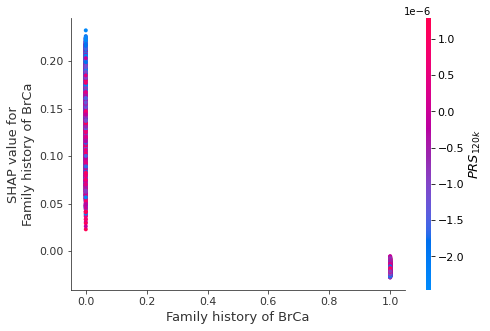

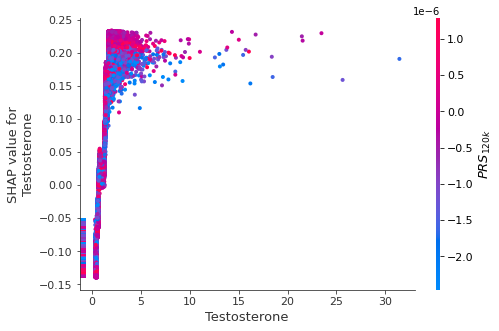

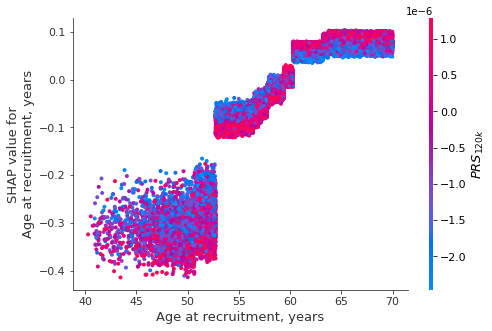

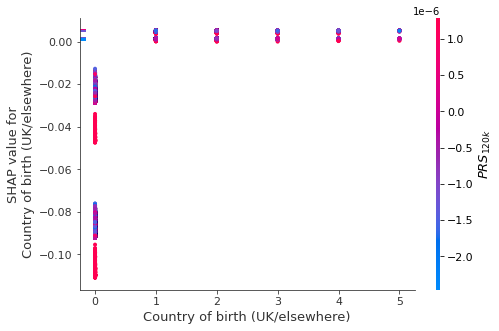

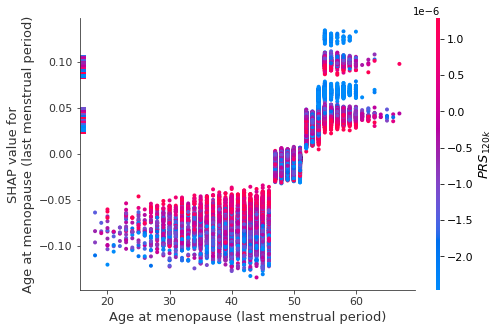

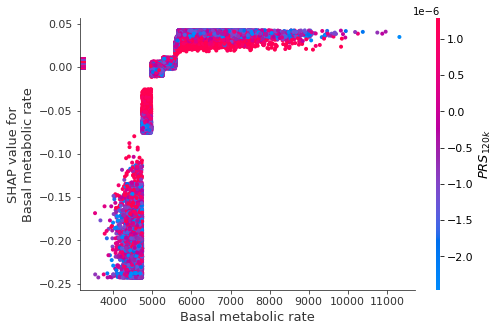

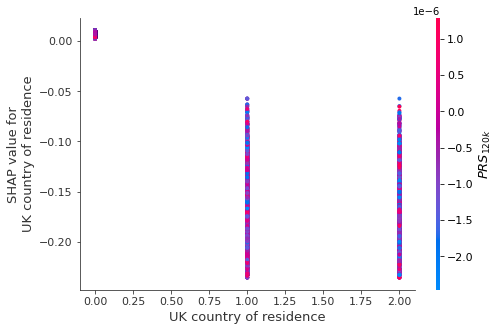

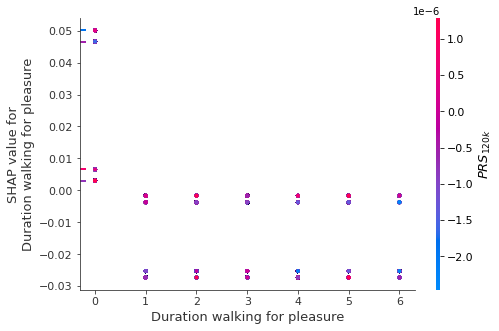

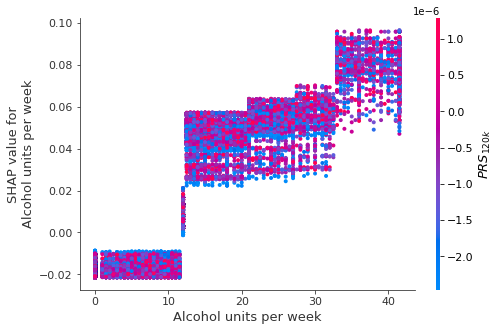

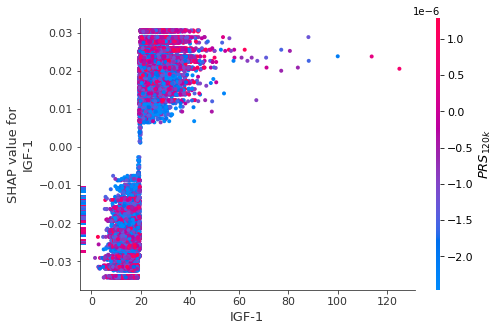

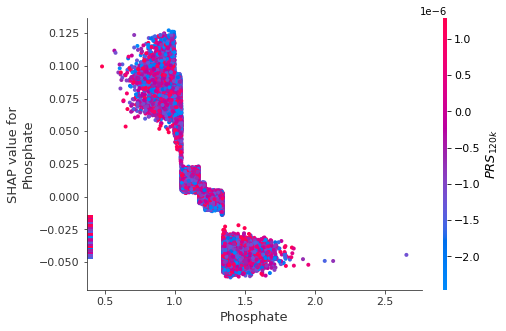

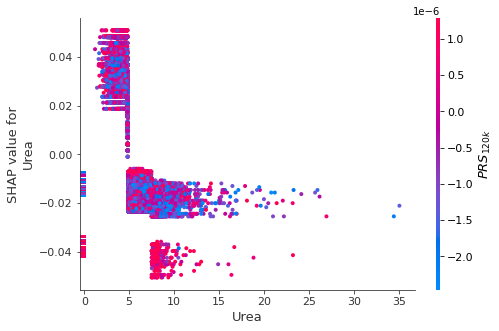

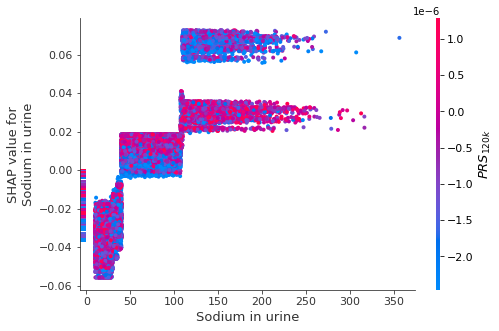

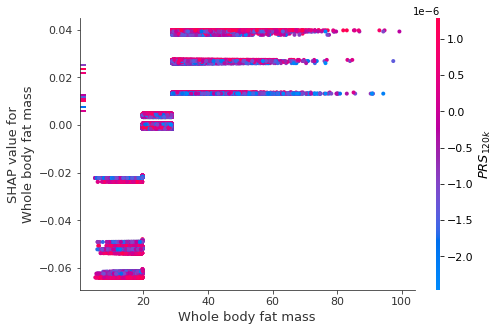

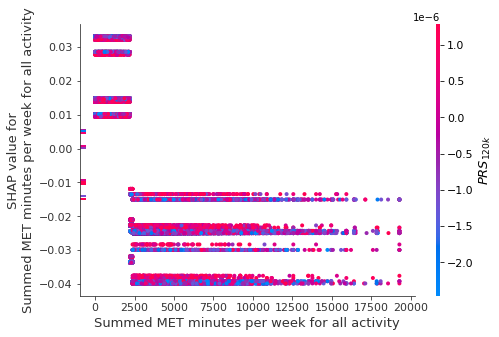

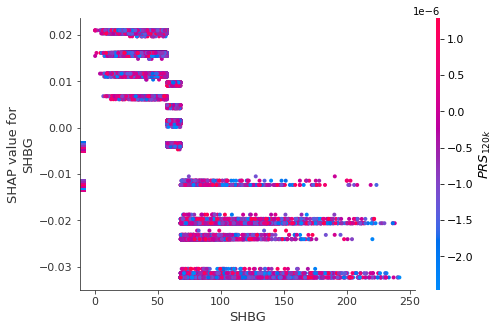

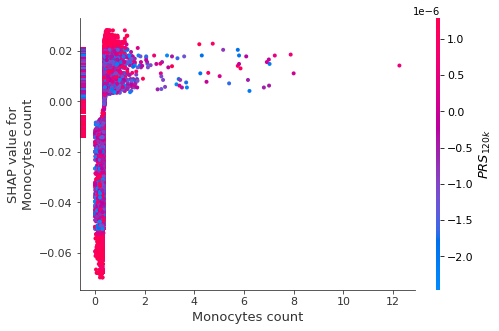

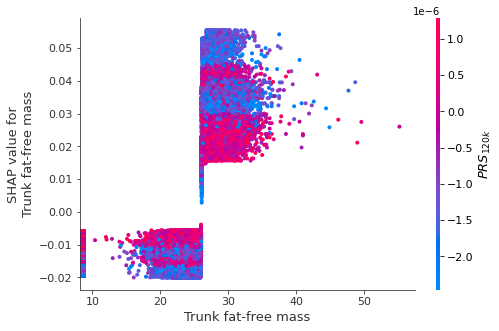

In [8]:
for name in feature_importance.Full_name[2:20]:
    shap.dependence_plot(str(name), shap_values, dtrain,feature_names=pretty_features,interaction_index='$PRS_{120k}$')

In [16]:
# Model performance on test set

# First make predictions on test set
Ypred=HistGBM_final.predict_proba(dtest)

# Compute AUC
test_auc=metrics.roc_auc_score(Ytest,Ypred[:,1])

print("AUC on test set: ",test_auc)

AUC on test set:  0.6633438957347277
